In [67]:
import numpy as np
from itertools import chain,tee, izip
from scipy.spatial.distance import cosine,euclidean
from pathos import multiprocessing as mp
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
import seaborn

In [10]:
np.set_printoptions(linewidth=75)

In [11]:
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')
bins = np.arange(0,1.01,.01)

## Support code

In [12]:
def calc_dist(idx_1,idx_2,metric='cosine'):
    if np.isnan(idx_1) or np.isnan(idx_2):
        return np.nan
    features1 = features[idx_1]
    features2 = features[idx_2]
    #if metric == 'JSD':
    #    return self.JSD(features1,features2)
    if metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return euclidean(features1,features2)

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

def calc_jump_dist(seq,bins=bins):
    distances = [calc_dist(a,b) for a,b in pairwise(seq)]
    result = np.histogram(distances,bins=bins)[0]
    return result / float(result.sum())
    

## Explore / Exploit regime switching

## Coherency maximizing

### Pólya urn model

In [13]:
artist_counts = np.array([int(line.strip().split(',')[1]) for line in open('../testData/artist_pop')],dtype=float)
base_probs = artist_counts / artist_counts.sum()

In [71]:
change = 10
def generate_seq(seed=None,n=1000,probs=base_probs.copy()):
    result = np.empty(n)
    if seed:
        np.random.seed(seed)

    for i in xrange(n):
        nxt = np.where(np.random.multinomial(1,probs)==1)[0][0]
        result[i] = nxt
        probs = adjust_weights(probs,nxt,change)
    
    return result


def adjust_weights(probs,idx,adj):
    new_probs = probs.copy()
    new_probs[idx] *= adj
    return new_probs / new_probs.sum()
    
    

In [72]:
def run(seed):
    seq = generate_seq(seed=seed)
    dist = calc_jump_dist(seq)
    #print seq[0]
    return dist

In [73]:
pool = mp.Pool(processes=4)
%time result = pool.map(run,np.random.randint(0,4294967295,1000))
pool.close()

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-package

CPU times: user 2.67 s, sys: 816 ms, total: 3.49 s
Wall time: 11min 33s


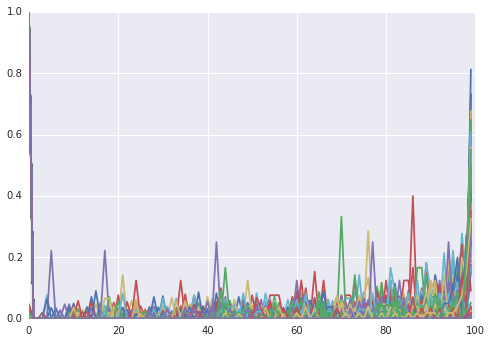

In [75]:
for row in result:
    plt.plot(row)

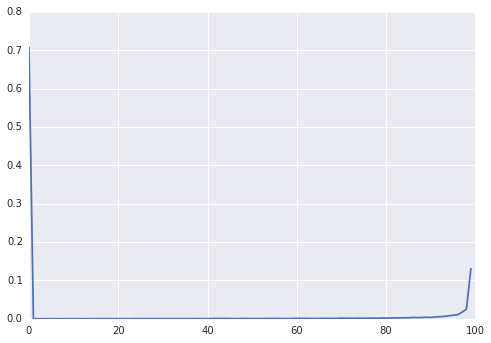

In [77]:
plt.plot(np.vstack(result).mean(0))